Shape after reading & datetime parse: (9357, 16)
After dropping NaN y: (8991, 9) 8991
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'model__alpha': np.float64(0.001), 'model__l1_ratio': 0.9}
CV R^2 (mean over folds): 0.9792015889752846
Test R^2:  0.9796
Test MSE:  1.1744
Test MAE:  0.7616
[Baseline] Single-variable R^2 using PT08.S2(NMHC): 0.9652


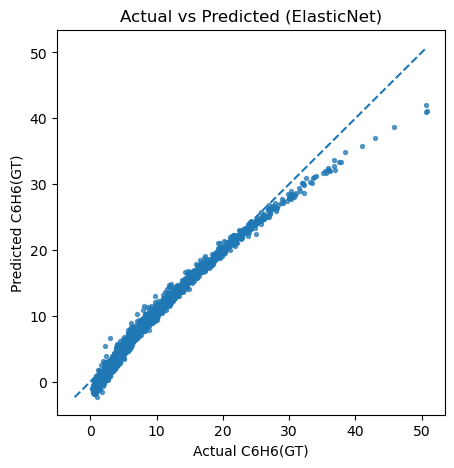

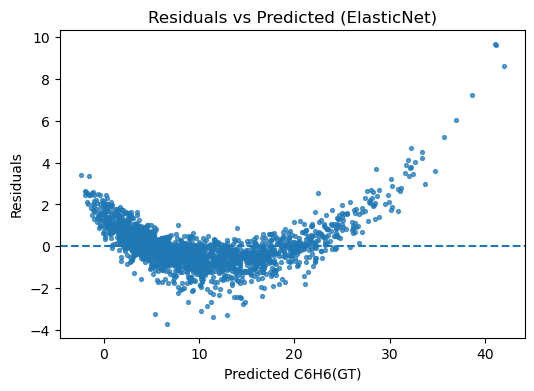

Model saved to elasticnet_pt08_datetime.joblib


In [9]:
# =========================================================
# Alysia – ElasticNet model using Experimental Sensors (PT08)
# Full pipeline: read -> clean -> feature engineering -> CV -> evaluate
# =========================================================

# -----------------------------
# 0) Imports and config
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1) Read in data (UCI CSV)
#    - separator: ';'
#    - decimal: ','
#    - datetime format like '10/03/2004 18.00.00' (dot separators)
# -----------------------------
file_path = r"C:\Users\19848\OneDrive\桌面\ST563\Project\AirQualityUCI.csv"

df = pd.read_csv(
    file_path,
    sep=';',
    decimal=',',
    encoding='utf-8',
    low_memory=False
)

# Drop empty trailing columns and empty rows (UCI file often has 2 empty cols)
df = df.dropna(axis=1, how='all')
df = df.dropna(how='all')

# Convert numeric columns from string to float (skip Date/Time)
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Strip whitespace in Date/Time and parse Datetime
df['Date'] = df['Date'].astype(str).str.strip()
df['Time'] = df['Time'].astype(str).str.strip()

# Try dot-separated time first; fallback to colon-separated if needed
dt = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                    format='%d/%m/%Y %H.%M.%S', errors='coerce')
if dt.isna().all():
    dt = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                        format='%d/%m/%Y %H:%M:%S', errors='coerce')

df['Datetime'] = dt
df = df.dropna(subset=['Datetime']).reset_index(drop=True)

print("Shape after reading & datetime parse:", df.shape)
df.head()

# -----------------------------
# 2) Define columns for Alysia's model
#    - Target: C6H6(GT)
#    - Predictors: PT08.S1–S5, T, RH, AH, plus datetime-derived (hour, month, season, dayofweek)
# -----------------------------
sensor_cols = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
met_cols    = ['T', 'RH', 'AH']
target_col  = 'C6H6(GT)'

# Ensure required columns exist
missing = [c for c in sensor_cols + met_cols + [target_col, 'Datetime'] if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# -----------------------------
# 3) Clean UCI sentinel (-200) and build X/y
# -----------------------------
# Replace -200 with NaN in sensors/met/target
for c in sensor_cols + met_cols + [target_col]:
    df.loc[df[c] == -200, c] = np.nan

# Build X and y
X = df[sensor_cols + met_cols + ['Datetime']].copy()
y = df[target_col].copy()

# Drop rows where target is missing (sklearn cannot fit with NaN in y)
y = y.astype(float).replace([np.inf, -np.inf], np.nan)
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("After dropping NaN y:", X.shape, len(y))

# -----------------------------
# 4) Datetime-derived features
# -----------------------------
X['hour']      = X['Datetime'].dt.hour
X['month']     = X['Datetime'].dt.month
X['season']    = (X['month'] % 12) // 3 + 1   # 1=Winter, 2=Spring, 3=Summer, 4=Fall
X['dayofweek'] = X['Datetime'].dt.dayofweek

# Drop raw Datetime after deriving features
X = X.drop(columns=['Datetime'])

# -----------------------------
# 5) Preprocessing + ElasticNet pipeline
#    - Numeric: impute median + standardize
#    - Categorical (time-based): impute most_frequent + one-hot
#    - ElasticNet with hyperparameter tuning
# -----------------------------
num_cols = sensor_cols + met_cols
cat_cols = ['hour', 'month', 'season', 'dayofweek']

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

enet = ElasticNet(max_iter=10000, random_state=42)

pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', enet)
])

param_grid = {
    'model__alpha': np.logspace(-3, 1, 12),   # 0.001 to 10
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# -----------------------------
# 6) Train/validation split & GridSearchCV
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("CV R^2 (mean over folds):", grid.best_score_)

# -----------------------------
# 7) Evaluate on held-out test set
# -----------------------------
y_pred = grid.predict(X_test)

r2  = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R^2:  {r2:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test MAE:  {mae:.4f}")

# Save predictions sample
pred_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred
}, index=y_test.index)
pred_df.head()

# -----------------------------
# 8) Optional baselines & diagnostics
# -----------------------------
# Baseline: single predictor PT08.S2(NMHC) -> Linear Regression
if 'PT08.S2(NMHC)' in X.columns:
    X_single = df[['PT08.S2(NMHC)']].copy()
    y_single = df[target_col].copy()
    # Clean sentinel for baseline too
    X_single.loc[X_single['PT08.S2(NMHC)'] == -200, 'PT08.S2(NMHC)'] = np.nan
    X_single = X_single.astype(float)
    y_single = y_single.astype(float)
    # Align indices and impute simple medians
    mask2 = y_single.notna()
    Xs = X_single.loc[mask2].copy()
    ys = y_single.loc[mask2].copy()
    Xs['PT08.S2(NMHC)'] = Xs['PT08.S2(NMHC)'].fillna(Xs['PT08.S2(NMHC)'].median())
    ys = ys.fillna(ys.median())

    Xs_train, Xs_test, ys_train, ys_test = train_test_split(
        Xs, ys, test_size=0.2, random_state=42
    )
    lin = LinearRegression().fit(Xs_train, ys_train)
    r2_single = lin.score(Xs_test, ys_test)
    print(f"[Baseline] Single-variable R^2 using PT08.S2(NMHC): {r2_single:.4f}")

# Diagnostics: Actual vs Predicted and Residuals
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual C6H6(GT)')
plt.ylabel('Predicted C6H6(GT)')
plt.title('Actual vs Predicted (ElasticNet)')
plt.show()

resid = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, resid, s=8, alpha=0.7)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted C6H6(GT)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (ElasticNet)')
plt.show()

# -----------------------------
# 9) Persist best model
# -----------------------------
best_model = grid.best_estimator_
joblib.dump(best_model, 'elasticnet_pt08_datetime.joblib')
print("Model saved to elasticnet_pt08_datetime.joblib")
